In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm

import numpy as np
import pandas as pd
import re, os, sys

import seaborn as sns
sns.set_style('white')

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
mpl.rcParams['pdf.fonttype'] = 42

import math

font_name = {'fontname':'Arial'}

plt.rcParams["font.family"] = "Arial"

import joblib

In [2]:
epath = r'N-LINKED_PATHWAY_STEPS_2022_YHU.xlsx'
e_df = pd.read_excel(epath)

/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [3]:
e_df

,PATH,PROTEIN,STEP,Monosaccharide
0,LLO,ALG5,1,Glucose
1,LLO,DPM1,2,Mannose
2,LLO,DPM2,2,Mannose
3,LLO,DPM3,2,Mannose
4,LLO,DOLK,3,NaN
...,...,...,...,...
123,Common,B3GALNT2,25,GalNAc
124,Common,B3GALT4,26,Galactose
125,Common,B3GALT5,26,Galactose
126,Common,CHST8,27,SO4


In [4]:
pathway_map = dict()
for index,row in e_df.iterrows():
    pathway = row['PATH']
    gene = row["PROTEIN"]
    if gene not in pathway_map:
        pathway_map[gene] = pathway

In [5]:
# get all gene symbos of glycosylation enzymes
ge = []
for index,row in e_df.iterrows():
    gene = row['PROTEIN']
    if "NOT " in gene:
        print(gene)
        continue
    if gene not in ge:
        ge.append(gene)
len(ge)

NOT IN HUMAN


111

In [6]:
notebook_dir = r"/Users/yingweihu/Documents/GitHub/GPNotebook/sample/PDAC/result/GPNotebook"
import cptac

In [7]:
pdac = cptac.Pdac()

cptac warning: Your version of cptac (1.1.2) is out-of-date. Latest is 1.5.7. Please run 'pip install --upgrade cptac' to update it. (/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/threading.py, line 910)


In [8]:
GPNotebook_dir = r"/Users/yingweihu/Documents/GitHub/GPNotebook"
data_name = "PDAC"

wd = os.path.join(GPNotebook_dir,"sample",data_name)

# meta folder
meta_dir = os.path.join(wd,"meta") 
sample_path = os.path.join(meta_dir, "Supplementary_table_1_v3.0.xlsx")

In [9]:
task_dir = os.path.join(wd,'result','GPNotebook','differential_expression_analysis')
if not os.path.exists(task_dir):
    os.mkdir(task_dir)


In [10]:
# input meta path: standardrized meta table
meta_path = os.path.join(wd,"meta/info.tsv")

# load meta data
meta_df = pd.read_csv(meta_path,sep="\t")
meta_df.head(10)

,Sample,CaseID,VitalStatus,SurvivalDays,Age,Gender,DeathCause,Stage
0,C3L-00102.N,C3L-00102,Deceased,249.0,42,Male,pancreatic carcinoma,Stage III
1,C3L-00189.N,C3L-00189,Deceased,1035.0,68,Female,pancreatic carcinoma,Stage IIB
2,C3L-00277.N,C3L-00277,Deceased,610.0,69,Male,pancreatic carcinoma,Stage IIB
3,C3L-00401.N,C3L-00401,Living,1228.0,62,Female,Unknown,Stage IIB
4,C3L-00640.N,C3L-00640,Living,594.0,59,Female,Unknown,Stage IIB
5,C3L-00819.N,C3L-00819,Deceased,602.0,74,Male,pancreatic carcinoma,Stage IIB
6,C3L-00881.N,C3L-00881,Living,3.0,80,Male,Unknown,Stage IIB
7,C3L-00928.N,C3L-00928,Deceased,761.0,58,Female,pancreatic carcinoma,Stage IIB
8,C3L-01031.N,C3L-01031,Living,369.0,64,Female,Unknown,Stage IB
9,C3L-01036.N,C3L-01036,Living,765.0,64,Male,Unknown,Stage IIB


In [11]:
tumor_samples = []
nat_samples = []

# read sample names
sample_df = pd.read_excel(sample_path,sheet_name="PDAC")

nd_samples = []

for index,row in sample_df.iterrows():
    status = row['Pathological.Status']
    sample = row['Sample.ID']
#     print(sample)
    if re.sub('PDA.','',sample) not in set(meta_df['Sample']) and status != 'Normal-duct':
        continue
    if status == "Tumor":
        tumor_samples.append(sample)
    elif status == 'NAT':
        nat_samples.append(sample)
    elif status == "Normal-duct":
        nd_samples.append(sample)
    else:
        print(sample)

In [12]:
#Let's get the proteomics data associated with Endometrial cancer; it was generated by the team at UMich
proteins = pdac.get_proteomics().T

In [13]:
proteins = proteins.applymap(lambda i: 0 if np.isinf(i) else float(i))

In [14]:
proteins.head(2)

Patient_ID,C3L-00017,C3L-00102,C3L-00189,C3L-00277,C3L-00401,C3L-00589,C3L-00598,C3L-00599,C3L-00622,C3L-00625,...,C3N-03069.N,C3N-03211.N,C3N-03426.N,C3N-03440.N,C3N-03780.N,C3N-03839.N,C3N-03840.N,C3N-03884.N,C3N-04119.N,C3N-04282.N
Name,,,,,,,,,,,,,,,,,,,,,
A1BG,28.601486,28.844697,29.095331,30.154566,27.945039,28.860579,29.304723,29.475239,28.169027,29.057885,...,28.266193,27.335147,29.039014,28.155401,27.869630,27.766448,27.377664,27.627408,27.504733,29.644077
A1CF,22.910654,22.992885,22.915704,23.340567,23.437183,23.561795,23.096600,23.931338,23.145892,23.201958,...,25.675240,26.033682,22.733953,25.221248,24.437578,25.151327,25.917166,25.130522,25.447099,23.001464


In [15]:
genz = proteins[proteins.index.isin(ge)]

In [16]:
genz

Patient_ID,C3L-00017,C3L-00102,C3L-00189,C3L-00277,C3L-00401,C3L-00589,C3L-00598,C3L-00599,C3L-00622,C3L-00625,...,C3N-03069.N,C3N-03211.N,C3N-03426.N,C3N-03440.N,C3N-03780.N,C3N-03839.N,C3N-03840.N,C3N-03884.N,C3N-04119.N,C3N-04282.N
Name,,,,,,,,,,,,,,,,,,,,,
A4GALT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ABO,19.731884,20.064155,NaN,20.908485,NaN,NaN,NaN,NaN,NaN,NaN,...,20.116830,21.878156,NaN,NaN,20.667449,NaN,NaN,NaN,NaN,19.015950
ALG1,22.261728,22.569675,23.757876,23.045768,23.389295,23.780391,23.146322,23.288256,23.651336,23.406180,...,23.397735,23.532191,22.855387,23.780086,24.428626,23.255539,24.452854,24.140841,23.777027,23.120486
ALG10,NaN,NaN,19.325044,NaN,NaN,18.616351,18.381213,21.105400,NaN,19.030496,...,NaN,19.456996,NaN,19.679384,19.246833,NaN,18.984746,19.163000,NaN,19.357965
ALG11,21.083520,22.218047,22.619669,22.081306,22.822214,22.551282,21.267164,22.393389,22.760729,22.537378,...,22.675775,23.175906,22.152062,23.163220,23.102228,22.769617,23.146275,23.134069,23.657850,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
STT3A,27.038399,27.403267,27.935333,26.319577,27.497640,27.742840,26.245524,27.212240,27.769907,27.817587,...,28.408463,30.083550,27.819632,29.508855,29.777887,29.906886,29.434201,29.905043,30.373863,26.589176
STT3B,24.630205,25.837989,25.807816,24.221348,25.131079,25.529268,23.871972,24.999612,25.817598,25.648157,...,26.520733,26.560579,25.281990,26.350235,26.318918,27.391006,26.352241,26.536410,26.826597,24.957247
TUSC3,19.490940,20.913387,20.740948,19.468158,NaN,NaN,19.779590,NaN,NaN,19.986640,...,NaN,20.805420,NaN,20.511973,20.875411,NaN,20.404763,NaN,NaN,19.702846


In [17]:
genz.shape

(73, 215)

In [18]:
cols = [i if re.search('\.N',i) else i + ".T" for i in list(proteins.columns.values)]
proteins.columns = cols

In [19]:
tumor_samples = [re.sub('^PDA\.','',i) for i in tumor_samples]

nat_samples = [re.sub('^PDA\.','',i) for i in nat_samples]

In [20]:
# input expression matrix path
data_dir = os.path.join(wd,"data")
expr_path = os.path.join(data_dir,"PDA_JHU_GENCODEv34_nglycoform-peptide_matrix-abundances-MD_norm.tsv")

glycopeps = pd.read_csv(expr_path,sep="\t",index_col=[0,1])
# convert string 'None' to np.nan
glycopeps = glycopeps.replace('None',np.nan)
# convert data to float
glycopeps = glycopeps.applymap(float)

In [21]:
glycopeps.head(2)

,,Intensity.Reference,PDA.Reference Sample 1,PDA.QC1,PDA.C3N-03884.T,PDA.C3L-00589.N,PDA.C3L-03123.N,PDA.C3L-01687.N,PDA.C3L-03123.T,PDA.C3L-01687.T,PDA.C3L-00589.T,...,PDA.C3L-03513.N,PDA.WU-PDA1.T,PDA.C3L-03514.N,PDA.C3L-03515.N,PDA.WU-pooled sample.T,PDA.C3L-07032.N,PDA.C3L-07033.N,PDA.C3L-07034.N,PDA.C3L-07035.N,PDA.C3L-07036.N
Sequence,Gene,,,,,,,,,,,,,,,,,,,,,
NDAGSYECEIQNPASANR-N5H5F1S0G0,CEACAM6|ENSG00000086548.9,10.042402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
QNQCFYNSSYLNVQR-N5H6F0S3G0,ORM2|ENSG00000228278.4,14.269021,14.269021,NaN,14.644848,13.588676,14.206348,15.351225,15.103154,13.881814,13.515957,...,14.256315,14.502623,13.446056,NaN,14.840462,10.75943,12.359499,13.446172,15.137718,13.807068


In [22]:
glycopeps.columns = [re.sub('PDA\.','',i) for i in glycopeps.columns.values]
genz.columns = [i if re.search('\.[NT]',i) else i + ".T" for i in genz.columns.values ]

In [23]:
all_samples = tumor_samples + nat_samples

In [24]:
genz = genz[all_samples]
glycopeps = glycopeps[all_samples]

In [25]:
genz.shape, glycopeps.shape

((73, 199), (30525, 199))

In [26]:
rows = []
for index,row in genz.iterrows():
    miss_samples = [i for i in list(row) if pd.isna(i)]
    if len(miss_samples) < len(all_samples) * 0.5:
        rows.append(row)
genz2 = pd.DataFrame(rows)

In [27]:
genz2.shape

(53, 199)

In [28]:
rows = []
for index,row in glycopeps.iterrows():
    miss_samples = [i for i in list(row) if pd.isna(i)]
    if len(miss_samples) < len(all_samples) * 0.5:
        rows.append(row)
glycopeps2 = pd.DataFrame(rows)

In [29]:
glycopeps2.shape

(6878, 199)

In [30]:
from scipy.stats import spearmanr,pearsonr

In [31]:
glycopeps2.head(2)

,,C3L-00017.T,C3L-00102.T,C3L-00189.T,C3L-00277.T,C3L-00401.T,C3L-00589.T,C3L-00598.T,C3L-00599.T,C3L-00622.T,C3L-00625.T,...,C3N-02295.N,C3N-00709.N,C3L-01031.N,C3L-01053.N,C3L-00401.N,C3N-03839.N,C3N-01011.N,C3N-03069.N,C3N-00512.N,C3L-02899.N
QNQCFYNSSYLNVQR-N5H6F0S3G0,ORM2|ENSG00000228278.4,15.077785,15.352008,15.654077,16.436145,NaN,13.515957,NaN,16.683333,14.800934,14.147499,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CIPVMEAQEYIANVTSSSSAK-N5H3F1S0G0,LEMD2|ENSG00000161904.12,13.543378,13.233498,NaN,NaN,13.339757,13.153550,12.961466,14.115281,13.427953,NaN,...,14.14926,15.196393,15.242452,15.090538,13.196396,14.317478,14.17382,14.47869,14.840501,13.930967


In [32]:
rows = []
for index,row in tqdm(genz2.iterrows()):
    gene = index
    protein_expr = np.array(list(row))
    r = []
    for index2, row2 in glycopeps2.iterrows():
        gp = index2
        glycopep_expr = np.array(list(row2))
        corr, p = spearmanr(protein_expr,glycopep_expr,nan_policy='omit')
        r.append(corr)
    rows.append(r)
    
corr_df = pd.DataFrame(rows,columns=glycopeps2.index,index = genz2.index)

53it [02:33,  2.89s/it]


In [33]:
corr_df.head(2)

,QNQCFYNSSYLNVQR-N5H6F0S3G0,CIPVMEAQEYIANVTSSSSAK-N5H3F1S0G0,NGIYNITVLASDQGGR-N2H5F0S0G0,TNSTFVQALVEHVK-N2H5F1S0G0,ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0,SLTQGSLIVGDLAPVNGTSQGK-N4H6F1S0G0,EFYVDQNVSIK-N2H9F0S0G0,IHYLYLQNNFITELPVESFQNATGLR-N9H10F3S0G0,DILNGTFSYK-N2H6F0S0G0,ITTTPTNGQQGNSLEEVVHADQSSCTFDNLSPGLEYNVSVYTVK-N8H5F0S0G0,...,HNNDTQHIWESDSNEFSVIADPR-N2H9F0S0G0,LESMPPGLPSSLMYLSLENNSISSIPEK-N4H5F0S2G0,IGDENCDPECNHTLTGHDGGDCR-N2H5F0S0G0,AQEALSMGNATFYEVESILK-N5H4F1S0G0,NNHTASILDR-N3H4F1S0G0,TGPVVEDSGSLLLEYVNGSACTTSDGR-N4H5F1S1G0,INGTQICPNDLVAFHDFSSDLENVPHLR-N6H7F1S3G0,TLSRPSETCNETTK-N2H6F0S0G0,NLQVYNATSNSLTVK-N5H3F0S0G0,DTAVFECLPQHAMFGNDTITCTTHGNWTK-N8H10F0S4G0
,ORM2|ENSG00000228278.4,LEMD2|ENSG00000161904.12,DSC2|ENSG00000134755.17,PSAP|ENSG00000197746.14,APOD|ENSG00000189058.9,HSPG2|ENSG00000142798.20,SVEP1|ENSG00000165124.18,PRELP|ENSG00000188783.6,FAP|ENSG00000078098.14,FN1|ENSG00000115414.20,...,HSP90B1|ENSG00000166598.15,OMD|ENSG00000127083.7,PAPPA|ENSG00000182752.10,LAMC2|ENSG00000058085.15,CD63|ENSG00000135404.11,IGF2R|ENSG00000197081.14,PRELP|ENSG00000188783.6,FKBP10|ENSG00000141756.19,COL12A1|ENSG00000111799.21,APOH|ENSG00000091583.11
ABO,-0.083160,0.498600,0.473884,-0.209005,-0.016190,0.196461,0.227352,0.099511,-0.040227,-0.279665,...,0.038438,-0.202112,-0.338585,0.170274,0.392662,0.110227,0.090898,-0.290600,-0.198206,-0.148950
ALG1,-0.231474,0.336992,0.276067,-0.091839,-0.035095,0.147037,0.120705,0.032720,0.126029,-0.230519,...,0.186591,-0.131285,-0.243395,0.097987,0.261282,0.010660,-0.097598,-0.256972,-0.214366,-0.298922


/Users/yingweihu/opt/anaconda3/envs/py39_glycositeatlas/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


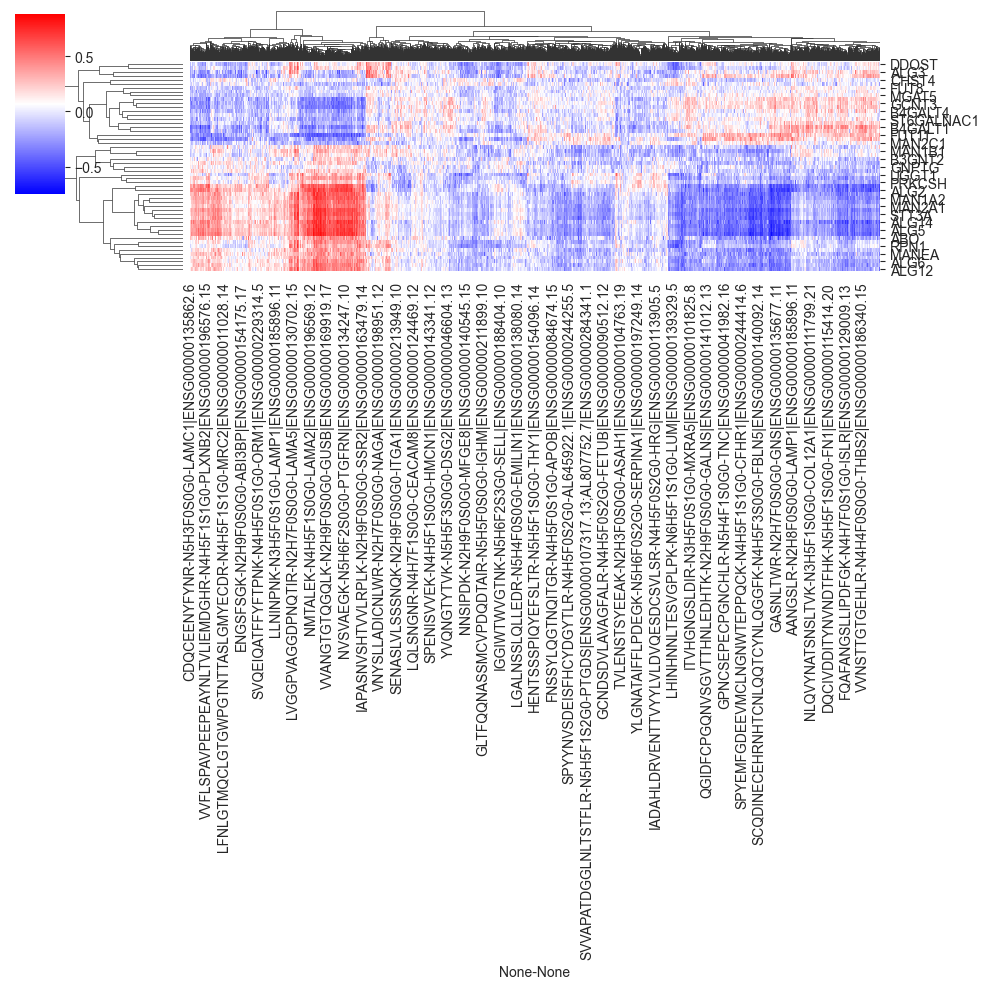

In [34]:
sns.clustermap(corr_df,cmap='bwr')

In [35]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Assume X is your data
X = corr_df.T.values

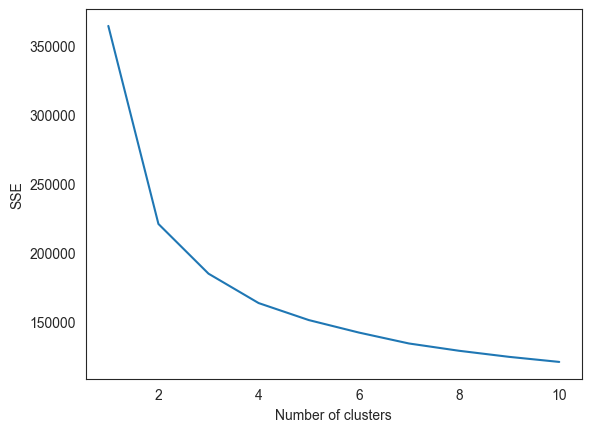

In [36]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Step 3: Preprocess the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 4: Use the Elbow method to find the optimal K
sse = {}
for k in range(1, 11):  # Test a range of K values
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    sse[k] = kmeans.inertia_  # Sum of squared distances to closest cluster center

# Plot SSE to find the elbow
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

In [37]:
import warnings

# Ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Use silhouette score to find the optimal K (higher is better)
silhouette_scores = {}
for k in range(2, 11):  # Start from 2 as silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores[k] = score

best_k = max(silhouette_scores, key=silhouette_scores.get)
print(f"Best K according to silhouette score is: {best_k}")

# Step 5: Cluster your data
kmeans = KMeans(n_clusters=best_k, random_state=42)
kmeans.fit(X_scaled)
cluster_labels = kmeans.labels_

# Step 6: Sort samples in each cluster
clusters = {}
for i in range(best_k):
    cluster_indices = np.where(cluster_labels == i)[0]
    cluster_points = X[cluster_indices]
    # Calculate distances to the cluster center
    distances = np.linalg.norm(cluster_points - kmeans.cluster_centers_[i], axis=1)
    # Sort by distance
    sorted_indices = distances.argsort()
    clusters[i] = cluster_indices[sorted_indices]

# Now, clusters is a dictionary where each key is a cluster index and each value is
# an array of data indices sorted by their association with the cluster.

# Example: Print the points in cluster 0 sorted by their association
print("Cluster 0:", X[clusters[0]])

Best K according to silhouette score is: 2
Cluster 0: [[ 0.47538462  0.29160787  0.583983   ...  0.31153994  0.36684174
  -0.25873387]
 [ 0.59722582  0.44733107  0.60070308 ...  0.32960015  0.2462774
  -0.2962206 ]
 [ 0.44386318  0.48425791  0.56767604 ...  0.41545942  0.26395092
  -0.16603869]
 ...
 [ 0.10611008  0.23359452  0.23360758 ...  0.06605054  0.5084498
   0.05436678]
 [-0.04325233  0.16598599  0.11774249 ...  0.05813443  0.61765342
  -0.21744612]
 [-0.12364054 -0.1565158   0.01608097 ... -0.09158986 -0.15649389
  -0.04095416]]


In [38]:
len(clusters[0])

2077

In [39]:
len(clusters[1])

4801

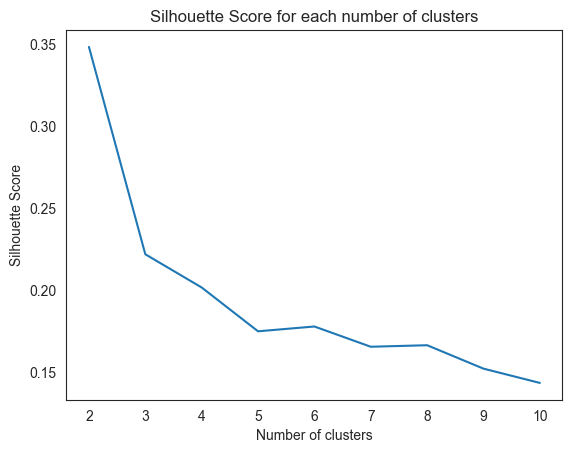

In [40]:
from sklearn.metrics import silhouette_score

silhouette_scores = []

# Assuming you have already scaled your data and called it X_scaled
for k in range(2, 11):  # silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42).fit(X_scaled)
    score = silhouette_score(X_scaled, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure()
plt.plot(range(2, 11), silhouette_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for each number of clusters')
plt.show()


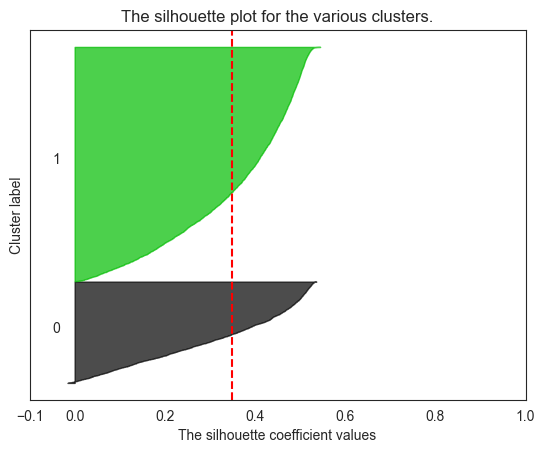

In [41]:
from sklearn.metrics import silhouette_samples
import matplotlib.cm as cm

# Choose an example number of clusters
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

y_lower = 10
for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
        sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples gap

plt.title("The silhouette plot for the various clusters.")
plt.xlabel("The silhouette coefficient values")
plt.ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
plt.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.yticks([])  # Clear the yaxis labels / ticks
plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


In [43]:
len(sample_silhouette_values)

6878

In [45]:
sample_silhouette_values[cluster_labels == 0]

array([0.47762336, 0.51615646, 0.03793493, ..., 0.45757395, 0.00686356,
       0.4830356 ])

In [46]:
cluster_labels

array([1, 0, 0, ..., 1, 1, 1], dtype=int32)

In [48]:
X_scaled.shape

(6878, 53)

In [49]:
X_scaled[0].shape

(53,)

In [50]:
X_scaled[0]

array([-0.28662402, -1.07597633, -0.81630082, -1.20244103, -0.49259959,
       -0.82758427, -0.96011887, -1.14784918, -1.17184285, -1.33531411,
       -1.36449602,  0.19955128, -0.27601449,  0.28611054, -0.2155464 ,
        0.56112863, -1.35642273, -0.33808834, -0.99680457, -1.02368119,
        0.04233585,  1.82544931,  0.74118431, -0.61847113,  1.37575345,
        1.48514079, -1.68677091,  1.09471236,  0.13976696, -1.23290572,
       -1.1926442 ,  1.30304761, -1.36226948, -0.05662996,  0.91881992,
       -0.68280467, -1.30138168, -1.15562734, -0.00734216,  0.6597377 ,
       -1.10387409, -0.32051969, -0.49662196, -0.95265716, -1.2213554 ,
        0.58023342,  0.59077061,  2.00440269, -1.42614951, -1.34087327,
       -0.44211605, -0.6031477 , -0.47728151])

In [54]:
corr_df.head(2)

,QNQCFYNSSYLNVQR-N5H6F0S3G0@ORM2,CIPVMEAQEYIANVTSSSSAK-N5H3F1S0G0@LEMD2,NGIYNITVLASDQGGR-N2H5F0S0G0@DSC2,TNSTFVQALVEHVK-N2H5F1S0G0@PSAP,ADGTVNQIEGEATPVNLTEPAK-N4H5F1S1G0@APOD,SLTQGSLIVGDLAPVNGTSQGK-N4H6F1S0G0@HSPG2,EFYVDQNVSIK-N2H9F0S0G0@SVEP1,IHYLYLQNNFITELPVESFQNATGLR-N9H10F3S0G0@PRELP,DILNGTFSYK-N2H6F0S0G0@FAP,ITTTPTNGQQGNSLEEVVHADQSSCTFDNLSPGLEYNVSVYTVK-N8H5F0S0G0@FN1,...,HNNDTQHIWESDSNEFSVIADPR-N2H9F0S0G0@HSP90B1,LESMPPGLPSSLMYLSLENNSISSIPEK-N4H5F0S2G0@OMD,IGDENCDPECNHTLTGHDGGDCR-N2H5F0S0G0@PAPPA,AQEALSMGNATFYEVESILK-N5H4F1S0G0@LAMC2,NNHTASILDR-N3H4F1S0G0@CD63,TGPVVEDSGSLLLEYVNGSACTTSDGR-N4H5F1S1G0@IGF2R,INGTQICPNDLVAFHDFSSDLENVPHLR-N6H7F1S3G0@PRELP,TLSRPSETCNETTK-N2H6F0S0G0@FKBP10,NLQVYNATSNSLTVK-N5H3F0S0G0@COL12A1,DTAVFECLPQHAMFGNDTITCTTHGNWTK-N8H10F0S4G0@APOH
ABO,-0.083160,0.498600,0.473884,-0.209005,-0.016190,0.196461,0.227352,0.099511,-0.040227,-0.279665,...,0.038438,-0.202112,-0.338585,0.170274,0.392662,0.110227,0.090898,-0.290600,-0.198206,-0.148950
ALG1,-0.231474,0.336992,0.276067,-0.091839,-0.035095,0.147037,0.120705,0.032720,0.126029,-0.230519,...,0.186591,-0.131285,-0.243395,0.097987,0.261282,0.010660,-0.097598,-0.256972,-0.214366,-0.298922


In [53]:
corr_df.columns = ['{}@{}'.format(i[0],i[1].split('|')[0]) for i in corr_df.columns.values]

In [56]:
glycopeps_scores = [(i,j,k) for i,j,k in zip(corr_df.columns.values,sample_silhouette_values,cluster_labels)]
glycopeps_scores[0]

('QNQCFYNSSYLNVQR-N5H6F0S3G0@ORM2', 0.48647808941579185, 1)

In [59]:
glycopeps_scores = sorted(glycopeps_scores,key=lambda i: (i[2],-i[1]))

In [60]:
glycopeps_scores[0]

('FLDNGGVLPTEEPPEEPAAPFPEPPANSTMGSK-N3H3F1S0G0@PDIA2', 0.5358841641901071, 0)

In [61]:
new_cols = [i for i,j,k in glycopeps_scores]

In [63]:
new_index = [i for i in ge if i in corr_df.index]

In [65]:
new_corr = corr_df.loc[new_index,new_cols]

In [79]:
e_df

,PATH,PROTEIN,STEP,Monosaccharide
0,LLO,ALG5,1,Glucose
1,LLO,DPM1,2,Mannose
2,LLO,DPM2,2,Mannose
3,LLO,DPM3,2,Mannose
4,LLO,DOLK,3,NaN
...,...,...,...,...
123,Common,B3GALNT2,25,GalNAc
124,Common,B3GALT4,26,Galactose
125,Common,B3GALT5,26,Galactose
126,Common,CHST8,27,SO4


In [94]:
# Define the color palette
pathway_lut = {
    'LLO':'dodgerblue', 
    'N-linked':'forestgreen', 
    'Common':'darkorange'
}
rows = []
find_genes = []
for index,row in e_df.iterrows():
    path = row['PATH']
    protein = row['PROTEIN']
    if protein not in find_genes:
        find_genes.append(protein)
    else:
        continue
    lut = pathway_lut.get(path)
    rows.append([protein,lut])
    
row_colors = pd.DataFrame(rows,columns=['Gene','PATH'])
row_colors = row_colors.set_index('Gene')

In [95]:
new_corr.head(2)

,FLDNGGVLPTEEPPEEPAAPFPEPPANSTMGSK-N3H3F1S0G0@PDIA2,HNNDTQHIWESDSNEFSVIADPR-N3H3F1S0G0@HSP90B1,FGCEIENNR-N5H5F2S0G0@AZGP1,AEPPLNASASDQGEK-N3H3F1S0G0@HYOU1,LLHALGGDDFLGMLNR-N2H9F0S0G0@PCYOX1,FLDNGGVLPTEEPPEEPAAPFPEPPANSTMGSK-N2H7F0S0G0@PDIA2,LLHALGGDDFLGMLNR-N2H6F0S0G0@PCYOX1,LLHALGGDDFLGMLNR-N2H7F0S0G0@PCYOX1,VINQTTCENLLPQQITPR-N2H5F0S0G0@ST14,LLHALGGDDFLGMLNR-N2H5F0S0G0@PCYOX1,...,GTAGNALMDGASQLMGENR-N4H4F0S1G0@FGB,IADTNITSIPQGLPPSLTELHLDGNK-N4H7F1S0G0@DCN,LQNNENNISCVER-N4H5F0S1G0@CFHR1,FGCEIENNR-N3H4F0S1G0@AZGP1,AAIPSALDTNSSK-N4H5F0S2G0@LGALS3BP,IADTNITSIPQGLPPSLTELHLDGNK-N3H4F1S1G0@DCN,LLGVGEEVGGVLELFPINGSSVVER-N4H5F1S1G0@CCDC80,NETLALPAESK-N4H5F1S1G0@ABI3BP,ADGTVNQIEGEATPVNLTEPAK-N4H6F2S0G0@APOD,GTAGNALMDGASQLMGENR-N4H5F2S0G0@FGB
ALG5,0.693339,0.555627,0.622677,0.644107,0.679811,0.668875,0.686263,0.692534,0.611882,0.651473,...,0.123245,0.164665,0.058649,0.126121,0.066675,0.120448,0.146414,0.087442,0.039688,0.079067
DPM1,0.376047,0.391298,0.362768,0.320315,0.324580,0.407687,0.335158,0.370196,0.277563,0.377533,...,0.004813,-0.217837,-0.005212,-0.098494,0.074022,0.058793,0.054154,-0.060024,0.040369,-0.003255


In [99]:

def decide_glycan_type(g):
    m = re.finditer('([A-Z])([\d]+)',g)
    y = [(i.group(1),int(i.group(2))) for i in m ]
    d = dict(y)
    glycan_type = 'Other'
    if d['N'] == 2 and d['H'] >= 5 and d['F'] == 0 and d['S'] == 0 and d['G'] == 0:
        glycan_type = 'HM'
    elif d['N'] >= 2 and d['H'] >= 3 and d['F'] > 0 and d['S'] == 0:
        glycan_type = 'only_F'
    elif d['N'] >= 2 and d['H'] >=3 and d['S'] > 0  and d['F'] ==  0:
        glycan_type = 'only_S'
    elif d['N'] >= 2 and d['H'] >=3 and d['S'] > 0 and d['F'] > 0:
        glycan_type = 'F+S'
    return glycan_type


def is_F(g):
    m = re.finditer('([A-Z])([\d]+)', g)
    y = [(i.group(1), int(i.group(2))) for i in m]
    d = dict(y)
    if d['F'] > 0:
        return True
    return False


def is_S(g):
    m = re.finditer('([A-Z])([\d]+)', g)
    y = [(i.group(1), int(i.group(2))) for i in m]
    d = dict(y)
    if d['S'] > 0:
        return True
    return False


def is_HM(g):
    x = decide_glycan_type(g)
    if x == 'HM':
        return True
    return False

In [134]:
cluster_lut = {
    0: 'blue',
    1: 'red'
}

glycan_lut = {
    'HM': 'green',
    'only_F': 'blue',
    'only_S': 'blue',
    'F+S': 'blue',
    'Other': 'red'
}
rows = []
for glycopep,score,cluster_label in glycopeps_scores:
    cluster_color = cluster_lut.get(cluster_label)
    m = re.search('^([A-Z]+)\-(N.+?)@(.+)$',glycopep)
    if m:
        seq = m.group(1)
        glycan = m.group(2)
        gene = m.group(3)
    else:
#         print(glycopep)
        continue
#     print(glycan)
    glycan_color = glycan_lut.get(decide_glycan_type(glycan))
#     print(glycan_color)
    rows.append([glycopep,cluster_color,glycan_color])

col_colors = pd.DataFrame(rows,columns=['Glycopeptide','Cluster','Glycan'])
col_colors = col_colors.set_index('Glycopeptide')

[]

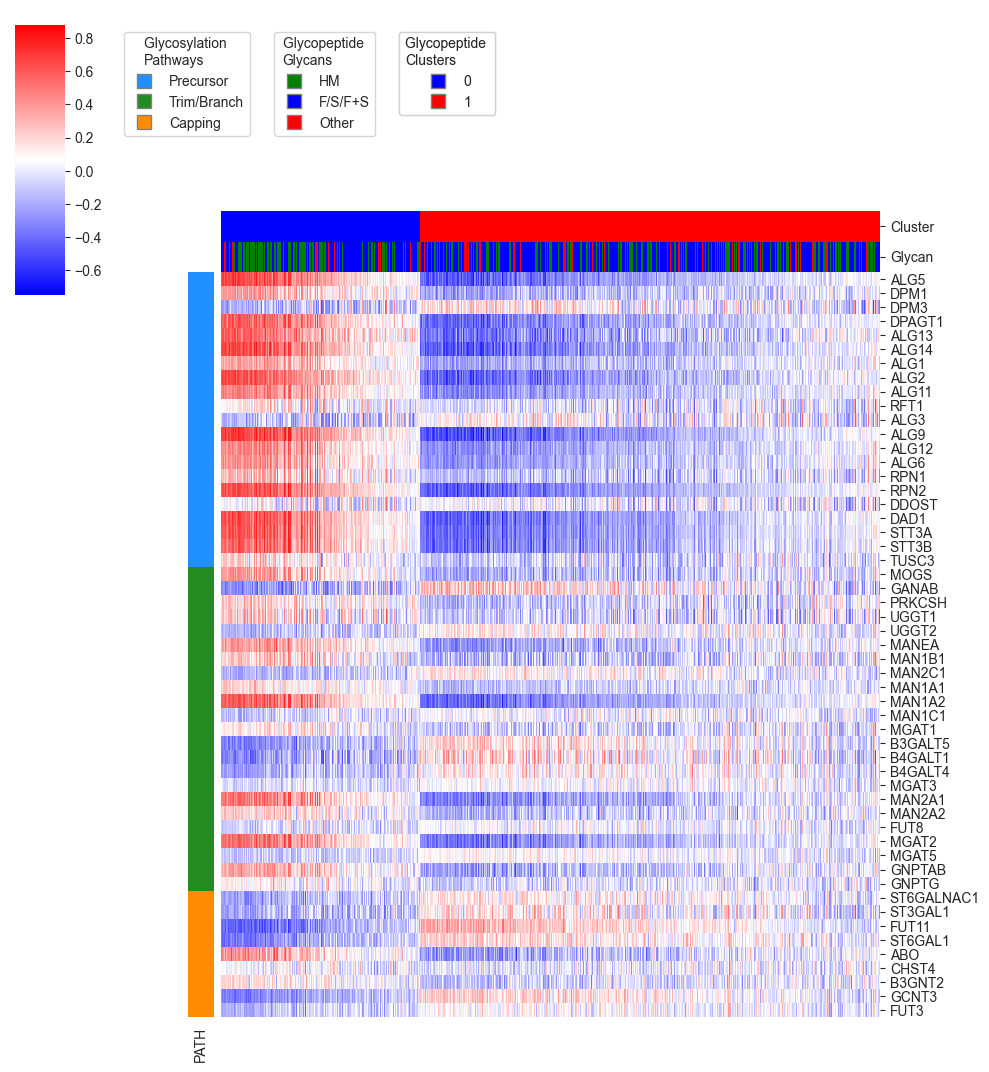

In [160]:
g = sns.clustermap(new_corr, row_cluster=False,col_cluster=False,cmap='bwr', figsize=(10,15),
                  row_colors=row_colors,col_colors=col_colors)

# first legend - glycosylation enzyme pathway
legend1_handles = []
legend1_labels = []

for i in pathway_lut:
    marker_color = pathway_lut[i]
    legend1_handles.append(
        plt.Line2D( [0], [0], color = 'grey', marker = 's',
                    linestyle = '', markersize = 10, markerfacecolor = marker_color
        )
    )
    if i == 'LLO':
        i = 'Precursor'
    if i == 'N-linked':
        i = 'Trim/Branch'
    if i == 'Common':
        i = 'Capping'
    legend1_labels.append(
        i
    )


# Add the second legend to the plot manually.
first_legend = plt.legend(handles=legend1_handles, labels=legend1_labels, 
                          title='Glycosylation \nPathways', 
                    bbox_to_anchor=(2.05, 1), loc='upper left')

plt.gca().add_artist(first_legend)

# add the second legend for glycopeptide clusters

legend2_handles = []
legend2_labels = []

find_glycans = []
for i in glycan_lut:
    glycan = i
    glycan_color = glycan_lut[i]
    if glycan == 'only_F' or glycan == 'only_S' or glycan == 'F+S':
        glycan = 'F/S/F+S'
    if glycan in find_glycans:
        continue
    else:
        find_glycans.append(glycan)
    legend2_handles.append(
        plt.Line2D( [0], [0], color = 'grey', marker = 's',
                    linestyle = '', markersize = 10, markerfacecolor = glycan_color
        )
    )
    
    legend2_labels.append(
        glycan
    )


# Add the second legend to the plot manually.
second_legend = plt.legend(handles=legend2_handles, labels=legend2_labels, title='Glycopeptide \nGlycans', 
                    bbox_to_anchor=(5.05, 1), loc='upper left')

plt.gca().add_artist(second_legend)


# third legend


legend3_handles = []
legend3_labels = []


for i in cluster_lut:
    cluster_color = cluster_lut[i]
    legend3_handles.append(
        plt.Line2D( [0], [0], color = 'grey', marker = 's',
                    linestyle = '', markersize = 10, markerfacecolor = cluster_color
        )
    )
    
    legend3_labels.append(
        i
    )

# Add the second legend to the plot manually.
third_legend = plt.legend(handles=legend3_handles, labels=legend3_labels, title='Glycopeptide \nClusters', 
                    bbox_to_anchor=(7.55, 1), loc='upper left')

plt.gca().add_artist(third_legend)

# Disable xticks on the heatmap
g.ax_heatmap.set_xticks([])